## Support Vector Machine: SMO

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scio
from sklearn.svm import LinearSVC

In [2]:
data = scio.loadmat('HW2_Data/data1')

In [3]:
X_trn = np.insert(data['X_trn'], 0, 1, axis=1)
y_trn = data['Y_trn']
X_tst = np.insert(data['X_tst'], 0, 1, axis=1)
y_tst = data['Y_tst']

In [4]:
X_train = np.matrix(X_trn)
y_train = np.matrix(y_trn)
X_test = np.matrix(X_tst)
y_test = np.matrix(y_tst)
y_train = np.where(y_train == 0, -1, 1)
y_test = np.where(y_test == 0, -1, 1)
K = np.dot(X_train, X_train.T)

In [5]:
def dual(X, y, b, alpha, i):
    temp = np.multiply(alpha, y)
    return temp.T * K[:, i] + b

In [6]:
def compute_eta(i, j):
    return 2 * K[i, j] - K[i, i] - K[j, j]

In [7]:
def new_alphaj_value(alpha, y, Ei, Ej, eta, L, H):
    temp = alpha - (y * (Ei - Ej)) / eta
    if temp > H:
        return H
    elif temp < L:
        return L
    else:
        return temp

In [8]:
def compute_b(b1, b2, alphai, alphaj, C):
    if 0 < alphai and alphai < C:
        return b1
    elif 0 < alphaj and alphaj < C:
        return b2
    else:
        return (b1 + b2) / 2

In [9]:
def smo(X, y, C, tolerance, max_passes):
    X = X[: , 1:]
    alpha = np.matrix(np.zeros(X.shape[0]))
    alpha = alpha.T
    b = 0
    passes = 0
    while passes < max_passes:
        num_changed_alphas = 0
        for i in range(len(X)):
            Ei = dual(X, y, b, alpha, i) - y[i]
            if (y[i] * Ei < -tolerance and alpha[i] < C) or (y[i] * Ei > tolerance and alpha[i] > 0):
                j = np.random.choice(len(X))
                while j == i:
                    j = np.random.choice(len(X))
                    
                Ej = dual(X, y, b, alpha, j) - y[j]
                old_alpha_i = alpha.item(i)
                old_alpha_j = alpha.item(j)
                
                if y[i] != y[j]:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(C, C + alpha[j] - alpha[i])
                else:
                    L = max(0, alpha[i] + alpha[j] - C)
                    H = min(C, alpha[i] + alpha[j])
                    
                if L == H:
                    continue
                
                eta = compute_eta(i, j)
                if eta >= 0:
                    continue
                    
                alpha[j] = new_alphaj_value(alpha[j], y[j], Ei, Ej, eta, L, H)
                
                if abs(alpha[j] - old_alpha_j) < 0.00001:
                    continue
                
                alpha[i] = alpha[i] + (y[i] * y[j] * (old_alpha_j - alpha[j]))
                
#                 # Compute b1 and b2
#                 b_1 = b - Ei - y[i]*(alpha[i] - old_alpha_i)* K[i,i] - y[j] *(alpha[j] - old_alpha_j)*K[i,j]
#                 b_2 = b - Ej - y[i]*(alpha[i] - old_alpha_i)* K[i,j] - y[j] *(alpha[j] - old_alpha_j)*K[j,j]

#                 b = b_1 if (alpha[i]>0 and alpha[i]<C) else(b_2 if (alpha[j]>0 and alpha[j]<C) else (b_1+b_2)/2)
                
                b1 = b - Ei - y[i] * (alpha[i] - old_alpha_i) * K[i, i] - y[j] * (alpha[j] - old_alpha_j) * K[i, j]
                b2 = b - Ej - y[i] * (alpha[i] - old_alpha_i) * K[i, j] - y[j] * (alpha[j] - old_alpha_j) * K[j, j]
                b = compute_b(b1, b2, alpha[i], alpha[j], C)
                
                num_changed_alphas += 1
        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0
    return alpha, b        
                
                

In [10]:
C=10
tolerance = 0.0001
max_passes = 3
alpha, b = smo(X_train, y_train, C, tolerance, max_passes)
print(b)

[[-0.50056877]]


In [11]:
def calculate_theta_smo(X_train, y_train, alpha, b):
    temp1 = np.matrix(np.multiply(alpha,y_train))
    theta_smo = np.dot(temp1.T,X_train[:, 1:])
    theta_smo = np.insert(theta_smo, 0, b)
    return theta_smo

In [12]:
theta_smo = calculate_theta_smo(X_train, y_train, alpha, b)

In [13]:
def plotPrediction(X, y, theta, title = 'train set'):
    X = np.concatenate((X, y), axis=1)
    X = np.array(X)
    X1 = X[np.ix_(X[:, 3] == -1, (1,2))]
    X2 = X[np.ix_(X[:, 3] == 1, (1,2))]
    minimum = np.floor(X2.min())
    maximum = np.ceil(X2.max())
    plt.scatter(X1[:, 0], X1[:, 1], marker='+', color="blue", label="Class 0")
    plt.scatter(X2[:, 0], X2[:, 1], marker='o', color="green", label="Class 1")
    x = np.linspace(-3, 3, 10)
    theta=np.array(theta)
    slope = -theta[:,1]/theta[:,2]
    intercept = -theta[:, 0]/theta[:,2]
    y_pred = slope*x + intercept
    plt.ylim(minimum, maximum)
    plt.plot(x, y_pred, color='red', label="Boundary")
    plt.title(title)
    plt.legend()
    plt.show()

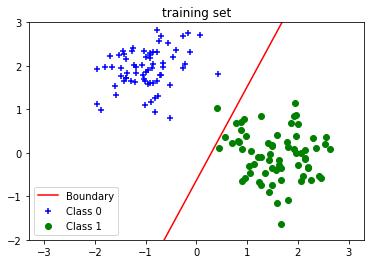

In [14]:
plotPrediction(X_train, y_train, theta_smo,"training set")

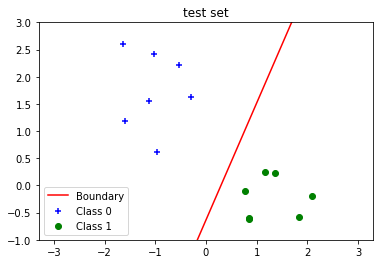

In [15]:
plotPrediction(X_test, y_test, theta_smo, "test set")

In [16]:
def predict(theta, X):  
    y_predict = np.sign((X[:,1:] * theta[:,1:].T) + theta[:,0])
    return y_predict

In [17]:
def classificationError(y, y_pred):
    count = 0
    for i in range(len(y)):
        if y_pred[i] != y[i]:
            count += 1
    return count

In [18]:
def classification_error_print(X_train, y_train, theta):
    y_pred = predict(theta, X_train)
    classification_error = classificationError(y_train, y_pred)
    classification_error_percent =  classification_error / len(y_pred) * 100
    print("Miss-classified points:", classification_error)
    print("The classification error percent is: {:0.2f}%".format(classification_error_percent))
    print("The accuracy is: {:0.2f}%".format(100 - classification_error_percent))

In [19]:
classification_error_print(X_train, y_train, theta_smo)

Miss-classified points: 1
The classification error percent is: 0.74%
The accuracy is: 99.26%


In [20]:
classification_error_print(X_test, y_test, theta_smo)

Miss-classified points: 0
The classification error percent is: 0.00%
The accuracy is: 100.00%


## Using SK learn

In [21]:
clf = LinearSVC(random_state=0)
clf.fit(X_train, y_train)

/Users/siddhantbenadikar/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=0, tol=0.0001,
     verbose=0)

In [22]:
def classification_error_print_sklearn(X_train, y_train):
    y_pred = clf.predict(X_train)
    classification_error = classificationError(y_train, y_pred)
    classification_error_percent =  classification_error / len(y_pred) * 100
    print("Miss-classified points:", classification_error)
    print("The classification error percent is: {:0.2f}%".format(classification_error_percent))
    print("The accuracy is: {:0.2f}%".format(100 - classification_error_percent))

In [23]:
clf.score(X_train, y_train)

1.0

In [24]:
classification_error_print_sklearn(X_train, y_train)

Miss-classified points: 0
The classification error percent is: 0.00%
The accuracy is: 100.00%


In [25]:
classification_error_print_sklearn(X_test, y_test)

Miss-classified points: 0
The classification error percent is: 0.00%
The accuracy is: 100.00%


In [26]:
theta_smo_sklearn = clf.coef_

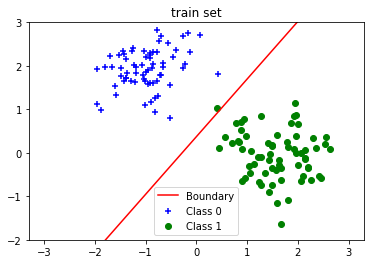

In [27]:
plotPrediction(X_train, y_train, theta_smo_sklearn, "train set")

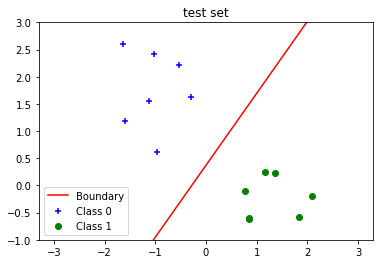

In [28]:
plotPrediction(X_test, y_test, theta_smo_sklearn, "test set")

In [29]:
train_err_list = []
test_err_list = []

for c in range(1,11):
    # Calculate α,b for training data
    alpha,b = smo(X_train, y_train, c, tolerance, max_passes)
    
    # Calculate theta
    temp = np.matrix(np.multiply(alpha,y_train))
    theta_smo = np.dot(temp.T,X_train)
    theta_smo[0,0] = b
    theta_smo
    
    # Mis-classification Error on Training
    y_pred = predict(theta_smo, X_train) 
    misclassified = classificationError(y_train, y_pred)
    err = misclassified / len(y_pred) * 100
    train_err_list.append(err)
    
    # Mis-classification Error on Test
    y_pred = predict(theta_smo, X_test) 
    misclassified = classificationError(y_test, y_pred)
    err = misclassified / len(y_pred) * 100
    test_err_list.append(err)

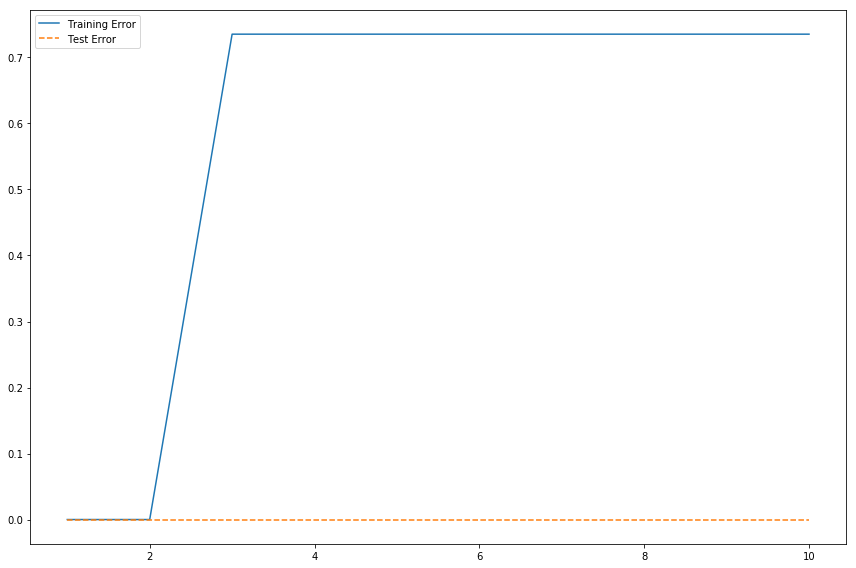

In [30]:
fig, ax = plt.subplots(figsize=(12,8))  

ax.plot(np.arange(1,11), train_err_list, '-', label='Training Error')
ax.plot(np.arange(1,11), test_err_list, '--', label='Test Error')

plt.legend()
fig.tight_layout()
plt.show()